# Naver Shopping

In [120]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x2848a70d850>)

In [121]:
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])
len(total_data)

200000

In [122]:
total_data

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [123]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default = 0)
total_data

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
199995,2,장마라그런가!!! 달지않아요,0
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,5,넘이쁘고 쎄련되보이네요~,1


In [124]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [125]:
total_data.drop_duplicates(subset = ['reviews'], inplace = True) # Review 열에서 중복인 내용이 있다면 중복 제거
total_data

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
199995,2,장마라그런가!!! 달지않아요,0
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,5,넘이쁘고 쎄련되보이네요~,1


In [126]:
total_data.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [127]:
train_data , test_data = train_test_split(total_data, test_size = 0.25, random_state = 40)
print("훈련용 데이터의 수 : ", len(train_data))
print("테스트용 데이터의 수 : ", len(test_data))

훈련용 데이터의 수 :  149931
테스트용 데이터의 수 :  49977


<AxesSubplot:>

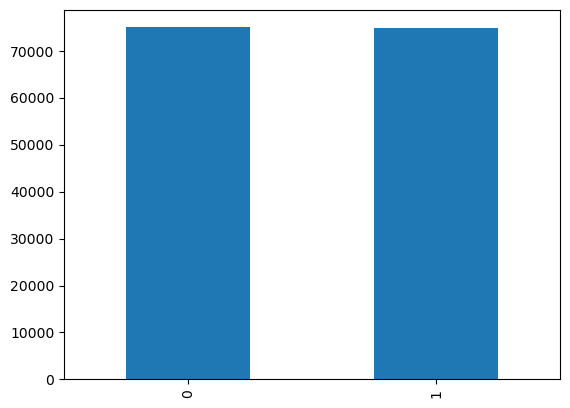

In [128]:
# 레이블 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [129]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,74991
1,1,74940


In [130]:
# 데이터 정제
# 정규표현식을 이용하여 한글을 제외하고 모두 제거해준다. 
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
train_data['reviews'].replace('', np.nan, inplace = True)
train_data.isnull().sum()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


ratings    0
reviews    0
label      0
dtype: int64

In [131]:
# test데이터에도 똑같이 해준다.
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


전처리 후 테스트용 샘플의 개수 : 49977


### Tokenize

In [132]:
! python --version

Python 3.7.0


In [133]:
from konlpy.tag import Mecab
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")

In [134]:
mecab.morphs("와 이런것도 상품이라고 차라리 내가 만드는 게 나을 뻔")

['와',
 '이런',
 '것',
 '도',
 '상품',
 '이',
 '라고',
 '차라리',
 '내',
 '가',
 '만드',
 '는',
 '게',
 '나을',
 '뻔']

In [135]:
# 불용어를 지정하여 필요없는 토큰들은 제거하기
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를',
            '인','듯','과','와','네','들','듯','지','임','계']

In [136]:
# 훈련데이터와 테스트에 데이터에 같은 과정을 거친다.
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if
                                                            item not in stopwords])

In [137]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x : [item for item in x if
                                                            item not in stopwords])

In [138]:
# 단어와 길이 분포 확인하기
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [139]:
negative_words_count = Counter(negative_words)
print(negative_words_count.most_common(20))

[('네요', 31808), ('는데', 20303), ('안', 19710), ('어요', 14868), ('있', 13293), ('너무', 13176), ('했', 11765), ('게', 11571), ('좋', 9761), ('배송', 9701), ('같', 8965), ('어', 8876), ('거', 8853), ('구매', 8761), ('없', 8729), ('아요', 8711), ('습니다', 8464), ('되', 8443), ('그냥', 8395), ('잘', 8072)]


In [140]:
positive_words_count = Counter(positive_words)
print(positive_words_count.most_common(20))

[('좋', 39596), ('아요', 20989), ('네요', 19834), ('잘', 18607), ('어요', 18512), ('구매', 16170), ('습니다', 13563), ('있', 12328), ('배송', 12315), ('게', 11746), ('는데', 11545), ('합니다', 9754), ('먹', 9738), ('했', 9642), ('재', 9408), ('너무', 8492), ('같', 7821), ('만족', 7239), ('거', 6545), ('쓰', 6340)]


긍정 리뷰의 평균 길이 :  13.737403255938084
부정 리뷰의 평균 길이 :  17.197210331906497


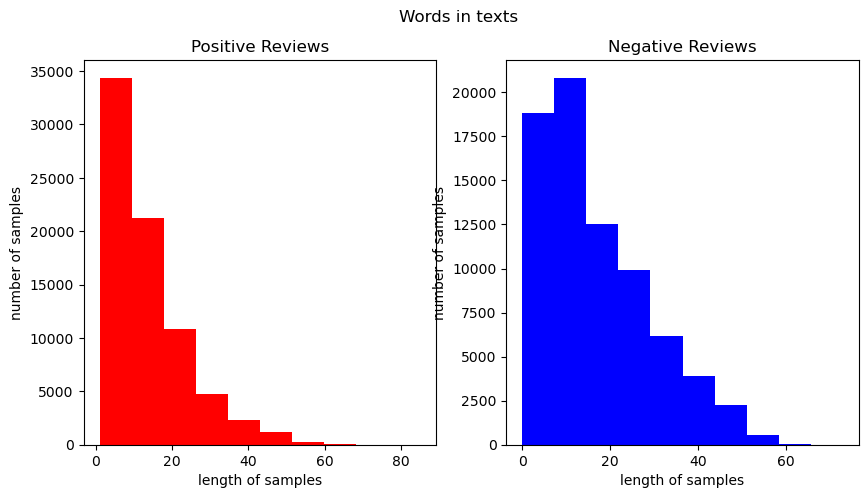

In [141]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x : len(x))
ax1.hist(text_len, color = 'red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel("number of samples")
print("긍정 리뷰의 평균 길이 : ", np.mean(text_len))

text_len = train_data[train_data['label'] ==0 ]['tokenized'].map(lambda x : len(x))
ax2.hist(text_len, color = 'blue')
ax2.set_title("Negative Reviews")
fig.suptitle("Words in texts")
ax2.set_xlabel('length of samples')
ax2.set_ylabel("number of samples")
print("부정 리뷰의 평균 길이 : ", np.mean(text_len))
plt.show()

In [142]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_train = test_data['label'].values

## 정수 인코딩

<br>

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다.
훈련 데이터에 대해서 단어 집합 (vacabulary) 를 만들어본다.

In [143]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [144]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threhosld 보다 작은 ㄷ단어의 등장 빈도수의 총 합

# 단어의 빈도수의 쌍(pair) 을 key 와 value 로 받는다.
for key, value in tokenizer.word_counts.items() :
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold 보다 작으면
    if (value < threshold) :
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합 (vocabulary)의 크기 : ', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 : %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 : ', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈동ㅔ서 희귀 단어 등장 빈도 비율 : ', (rare_freq / total_freq) * 100)

단어 집합 (vocabulary)의 크기 :  39985
등장 빈도가 1번 이하인 희귀 단어의 수 : 18191
단어 집합에서 희귀 단어의 비율 :  45.494560460172565
전체 등장 빈동ㅔ서 희귀 단어 등장 빈도 비율 :  0.7843933704077889


In [145]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
# 0번 패딩 토큰과 1번 00V 토큰을 고려하여 + 2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  21796


In [146]:
# 텍스트 시퀀스를 정수 시퀀스로 바꾸어주기.
# 정수 인코딩 과정에서 이보다 더 큰 숫자가 부여된 단어들은 OOV로 변환
tokenizer = Tokenizer(vocab_size , oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [147]:
print(X_train[:3])

[[461, 32, 461, 32, 10384, 309, 9, 15, 5, 552, 85, 587, 98, 89, 1859, 2], [1, 2357, 55, 15, 5, 2879, 1478, 2, 50, 166, 61, 611, 585, 124], [6271, 162, 57, 2590, 422, 4, 123, 23, 593, 807, 2287, 42, 3441, 12579, 32, 130, 224, 64, 13, 236, 211, 2376, 221, 172, 476, 58, 812, 127, 112, 9, 363, 247, 211, 685, 1017, 290, 118, 49, 2120, 42]]


In [148]:
print(X_test[:3])

[[303, 31, 47, 56, 13, 14, 1784, 880, 62, 833, 277], [860, 287, 31, 11, 21, 38, 5, 54, 51], [510, 1614, 14, 390, 66, 1516, 602, 100, 15, 12, 47, 53, 37, 14, 3, 2, 152, 126, 485, 137, 52, 348, 42, 1093, 1535, 32, 81, 64, 825, 2415, 1093, 92, 309, 314, 46, 1280, 406, 15, 12, 1553, 406, 1, 372, 9, 15, 117, 563, 87]]


## 패딩 (Padding)

<br>

- 서로 다른 샘플들의 길이를 똑같이 맞추어주는 패딩 작업 진행
- 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아본다.

리뷰의 최대 길이 :  85
리뷰의 평균 길이 :  15.467895231806631


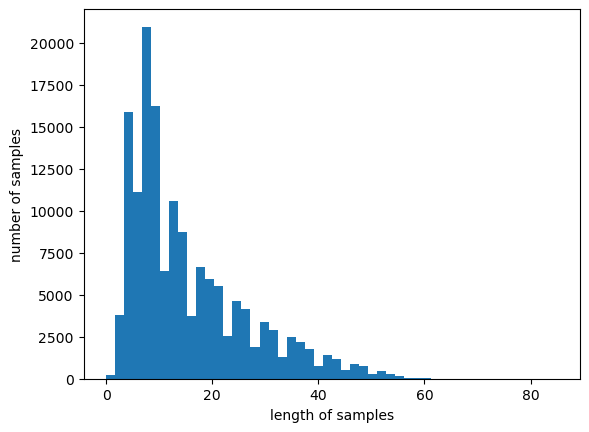

In [149]:
print('리뷰의 최대 길이 : ', max(len(review) for review in X_train))
print('리뷰의 평균 길이 : ', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [150]:
def below_threshold_len(max_len, nested_list) :
    count = 0
    for sentence in nested_list :
        count = count + 1
    print('전체 샘플 길이 중 길이가 %s 이하인 샘플의 비율 : %s' %(max_len, (count / len(nested_list)) * 100))

In [151]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 길이 중 길이가 80 이하인 샘플의 비율 : 100.0


In [152]:
# 훈련용 리뷰를 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [153]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [154]:
#!pip install keras==2.4.3
#!pip install tensorflow==2.2

In [ ]:
!pip install tensorflow==2.4
!pip install numpy==1.19.5

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1,
                    save_best_only = True)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks = [es, mc],
                   batch_size = 64, validation_split = 0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model.evaludate(X_test, y_test)[1]))

In [ ]:
def sentiment_predict(new_sentence) :
    new_sentence = re.sub(r'[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','',new_sentence)
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_seqneces([new_sentence])
    pad_new = pad_seqences(encoded, maxlen = max_len)
    
    score = float(laded_model.predict(pad_new))
    if(score > 0.5) :
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else :
        print("{.2f}% 확률로 부정 리뷰입니다.".format(score * 100))